# Load Processed Data

* This data was created by running the notebook prepare-data.ipynb

In [1]:
import pickle, os

home_dir = "../data"
processed_data_pkl = os.path.join(home_dir, "processed_data.pkl")

with open(processed_data_pkl, 'rb') as f:
    data_df, exclude_features, analytics = pickle.load( f)

print(data_df.shape)


(1301293, 200)


In [2]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

## Some statistics

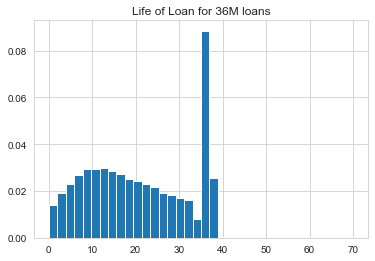

In [49]:
short_df = data_df.loc[data_df['term']<0.5,:]

plt = short_df['LifeOfLoan'].hist(cumulative=False, density=1, bins=36)
plt.title.set_text("Life of Loan for 36M loans")

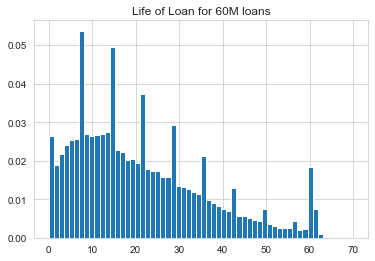

In [50]:
long_df = data_df.loc[data_df['term']>0.5,:]

plt = long_df['LifeOfLoan'].hist(cumulative=False, density=1, bins=60)
plt.title.set_text("Life of Loan for 60M loans")


5.31 30.99


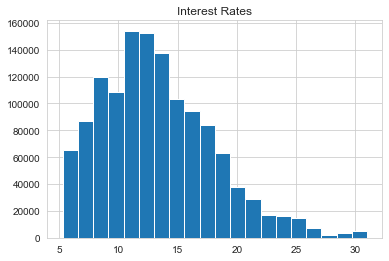

In [51]:
plt = data_df['int_rate'].hist(bins=20)
plt.title.set_text("Interest Rates")
print(data_df.int_rate.min(), data_df.int_rate.max())

In [52]:
del short_df
del long_df

In [53]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20, 10
rcParams['font.size'] = 22

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [54]:
def print_score(clf, X_train, y_train, X_test, y_test, train=False, plot_features=False, features=None):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  
        
    if plot_features and features is not None:
        # Get top features
        feature_importances = pd.DataFrame(clf.feature_importances_, 
                                   index = features,
                                   columns=['importance']).\
                                   sort_values('importance',ascending=False)
        # Plot
        feature_importances.iloc[:10,:].plot(kind='barh')
        plt.show()

In [55]:
def train_and_score(data_train, data_test, features, target, score=False, plot_features=False):
    
    print("Extracting train and test data")
    
    X_train = data_train[features]
    y_train = data_train[target]
    
    print('\tX_train shape: {} \t y_train shape: {}'.format(X_train.shape, y_train.shape))

    X_test = data_test[features]
    y_test = data_test[target]
    
    print('\tX_test  shape: {} \t y_test  shape: {}'.format(X_test.shape, y_test.shape))

    # Train Loan Acceptance classifier
    print("Training classifier")
    acceptance_classifier = RandomForestClassifier(n_estimators=40, random_state=21, class_weight=None)
    out = acceptance_classifier.fit(X_train, y_train)
    print(out)
    
    if score:
        print_score(acceptance_classifier, 
                X_train, y_train, 
                X_test,  y_test , train=False, plot_features=plot_features)
    
    return acceptance_classifier

# Generate train, test, and validate sets

In [56]:
# split validate set
v_size = 0.5
idx, idx_validate = \
            train_test_split(data_df.index, test_size=v_size, random_state=101)

# split train / test sets
test_size = 0.15
idx_train, idx_test = \
            train_test_split(idx, test_size=test_size)

# Define train, test, and validate df
train_df    = data_df.loc[idx_train, :]
test_df     = data_df.loc[idx_test, :]
validate_df = data_df.loc[idx_validate, :]

print("Number of loans in Train    set: {}".format(train_df.shape[0]))
print("Number of loans in Test     set: {}".format(test_df.shape[0]))
print("Number of loans in Validate set: {}".format(validate_df.shape[0]))

Number of loans in Train    set: 553049
Number of loans in Test     set: 97597
Number of loans in Validate set: 650647


# Train classifier

## Use core features

In [57]:
# features to delete

features_to_delete = [ 
    'acc_now_delinq', 'acc_open_past_24mths', 'application_type', 'avg_cur_bal',
    'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
    'collections_12_mths_ex_med', 
    'disbursement_method',
    'delinq_2yrs', 'delinq_amnt',   
    'initial_list_status',
    'inq_last_6mths',  'mort_acc', 
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mths_since_recent_bc', 'mths_since_recent_inq',
    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
    'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'num_accts_ever_120_pd','num_actv_bc_tl', 'num_actv_rev_tl',
    'open_acc', 
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'policy_code', 'pub_rec',  'pub_rec_bankruptcies', 
    'revol_bal', 'revol_util',
    'tax_liens',
    'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
    'total_bc_limit', 'total_il_high_credit_limit',  'total_rev_hi_lim'
]
all_features  = all_features = [col for col in data_df.columns if col not in exclude_features and col not in analytics]
core_features = [col for col in all_features if col not in features_to_delete]

print(core_features)

['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'earliest_cr_line_age', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improv

In [58]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}


# Train classifier with balanced core features
clf_core = train_and_score(train_df, test_df, core_features, 'LoanStatus', **options )

Extracting train and test data
	X_train shape: (553049, 115) 	 y_train shape: (553049,)
	X_test  shape: (97597, 115) 	 y_test  shape: (97597,)
Training classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)
Test Result:

accuracy score: 0.7991

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.98      0.89     78140
         1.0       0.48      0.08      0.13     19457

    accuracy                           0.80     97597
   macro avg       0.64      0.53      0.51     97597
weighted avg  

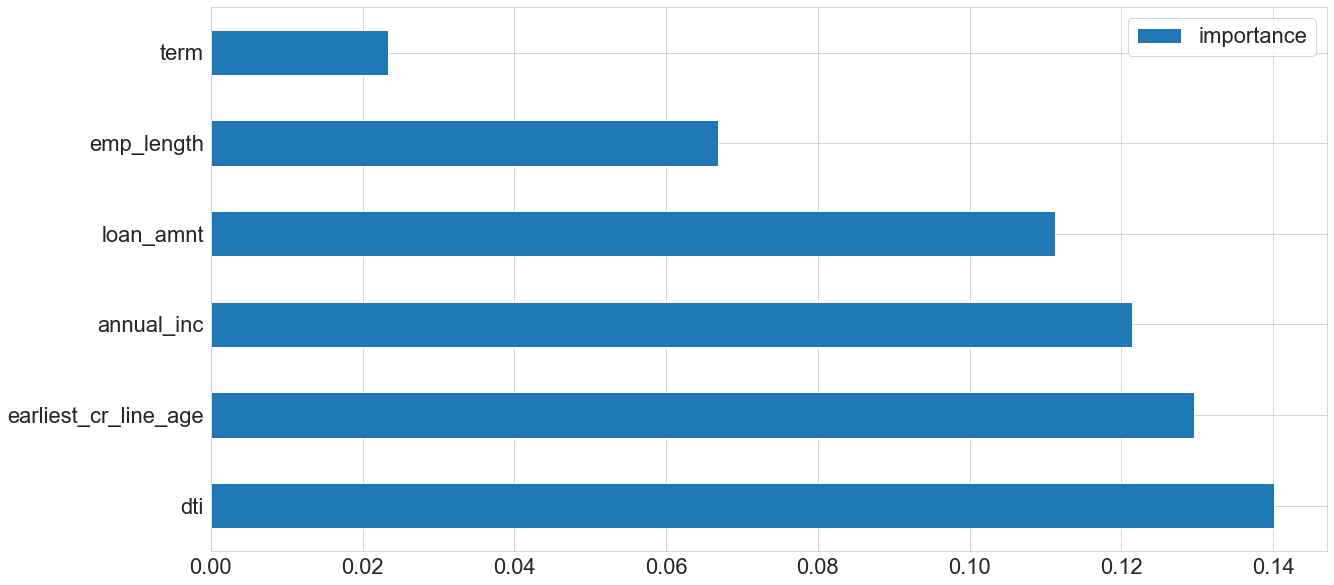

In [65]:
# Get top features
feature_importances = pd.DataFrame(clf_core.feature_importances_, 
                           index = core_features,
                           columns=['importance']).\
                           sort_values('importance',ascending=False)
# Plot
feature_importances.iloc[:6,:].plot(kind='barh')


In [77]:
test_df.loc[:,'CO_score'] = clf_core.predict_proba(test_df.loc[:,core_features])[:,1]
test_df.loc[:,'FP_score'] = clf_core.predict_proba(test_df.loc[:,core_features])[:,0]

In [83]:
fp_df = test_df.loc[test_df['LoanStatus'] < 0.5, :]
co_df = test_df.loc[test_df['LoanStatus'] > 0.5, :]


In [100]:
print(fp_df.shape[0])
print(co_df.shape[0])

78140
19457


In [125]:
test = np.linspace(0.625, 0.875, 5)

for t in test:
    print("\nDefault Score",1- t)
    print("\tTP  {0:6d} \tFN {1:6d}".format(fp_df.loc[fp_df['FP_score']>t,'FP_score'].count(), fp_df.loc[fp_df['FP_score']<t,'FP_score'].count() ))

    print("\tFP  {0:6d} \tTN {1:6d}".format(co_df.loc[co_df['FP_score']>t,'CO_score'].count(), co_df.loc[co_df['FP_score']<t,'CO_score'].count()))


Default Score 0.375
	TP   69733 	FN   6639
	FP   14184 	TN   4359

Default Score 0.3125
	TP   65054 	FN  13086
	FP   12157 	TN   7300

Default Score 0.25
	TP   54315 	FN  19691
	FP    8656 	TN   9537

Default Score 0.1875
	TP   44723 	FN  33417
	FP    6158 	TN  13299

Default Score 0.125
	TP   26859 	FN  45060
	FP    2683 	TN  15718


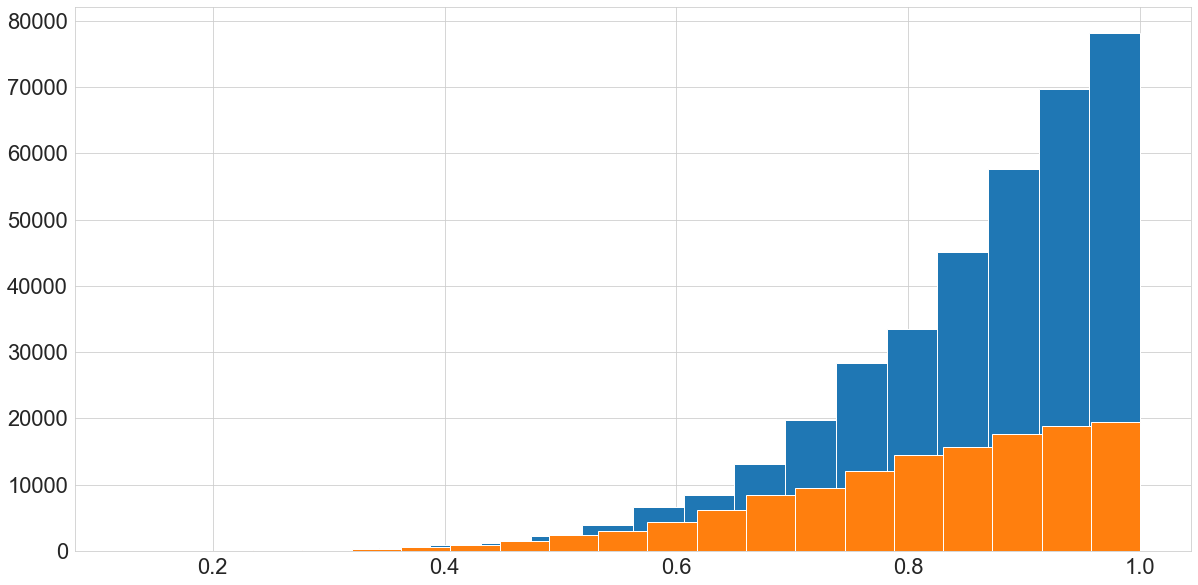

In [112]:
fp_df['FP_score'].hist(cumulative=True, bins=20)
co_df['FP_score'].hist(cumulative=True, bins=20)

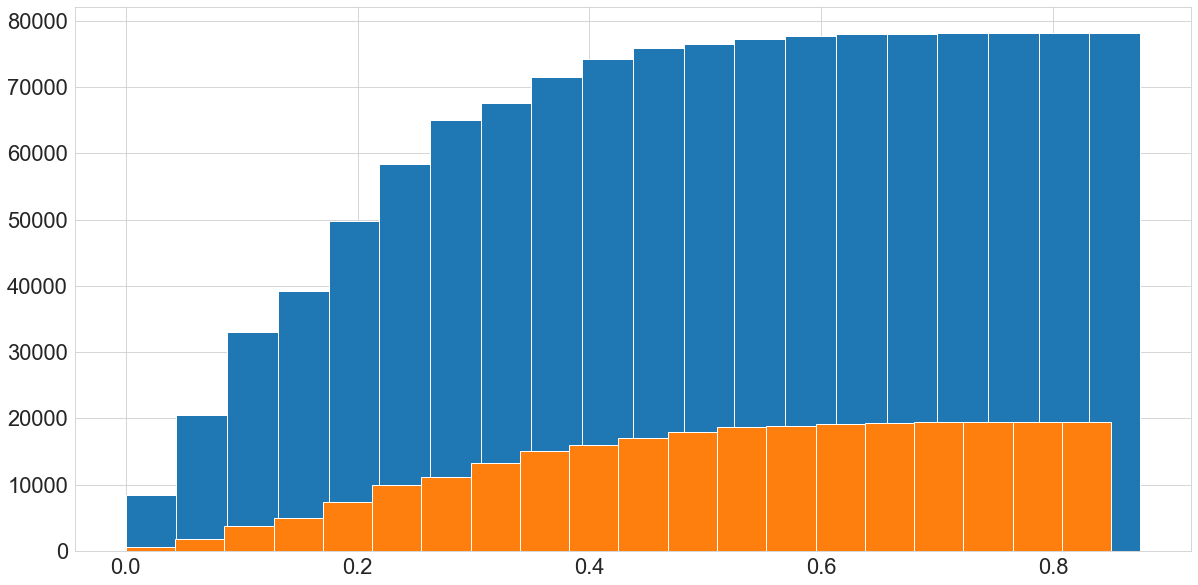

In [90]:
fp_df['CO_score'].hist(cumulative=True, bins=20)
co_df['CO_score'].hist(cumulative=True, bins=20)

In [12]:
charge_off_classifier_core_pkl = os.path.join(home_dir, "co_clf_core.pkl")

with open(charge_off_classifier_core_pkl,'wb') as f:
    pickle.dump((data_df, idx_train, idx_test, idx_validate, clf_core, core_features, analytics), f)